## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1.** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
user_rate = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

In [3]:
user_rate.head(1)

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000


In [4]:
user_rate.userID.values.max(), user_rate.userID.values.min()

(71534, 75)

In [5]:
user_rate['list'] = user_rate[['movieID', 'rating', 'timestamp']].values.tolist()

In [6]:
user_rate.head(5)

,userID,movieID,rating,timestamp,list
0,75,3,1.0,1162160236000,"[3.0, 1.0, 1.162160236e+12]"
1,75,32,4.5,1162160624000,"[32.0, 4.5, 1.162160624e+12]"
2,75,110,4.0,1162161008000,"[110.0, 4.0, 1.162161008e+12]"
3,75,160,2.0,1162160212000,"[160.0, 2.0, 1.162160212e+12]"
4,75,163,4.0,1162160970000,"[163.0, 4.0, 1.16216097e+12]"


In [7]:
# лист листов для каждого пользователя
user_rate = user_rate.groupby(by='userID')['list'].apply(list) 
# запишем в датафрейм
user_rate = pd.DataFrame({'list':user_rate.values, 'userID':user_rate.index})
# для каждого пользователя сортируем по таймстэмпу
user_rate['list'] = user_rate['list'].apply(lambda x: sorted(x, key=lambda y: y[2]))

print user_rate.iloc[0].list

[[2011.0, 2.0, 1162160199000.0], [420.0, 2.0, 1162160202000.0], [160.0, 2.0, 1162160212000.0], [1304.0, 2.5, 1162160216000.0], [353.0, 3.5, 1162160220000.0], [653.0, 3.0, 1162160225000.0], [920.0, 0.5, 1162160228000.0], [3.0, 1.0, 1162160236000.0], [1374.0, 4.0, 1162160240000.0], [2054.0, 1.5, 1162160253000.0], [173.0, 3.5, 1162160257000.0], [1485.0, 4.0, 1162160266000.0], [832.0, 4.5, 1162160269000.0], [2700.0, 4.5, 1162160272000.0], [2640.0, 3.0, 1162160276000.0], [6225.0, 0.5, 1162160485000.0], [2688.0, 3.0, 1162160546000.0], [3889.0, 3.0, 1162160563000.0], [32.0, 4.5, 1162160624000.0], [1527.0, 4.5, 1162160641000.0], [7007.0, 4.5, 1162160655000.0], [1036.0, 4.0, 1162160685000.0], [296.0, 5.0, 1162160689000.0], [32587.0, 5.0, 1162160691000.0], [2762.0, 3.5, 1162160694000.0], [7000.0, 3.5, 1162160708000.0], [1370.0, 4.0, 1162160711000.0], [165.0, 4.5, 1162160715000.0], [32029.0, 4.5, 1162160718000.0], [3994.0, 3.5, 1162160724000.0], [45431.0, 3.5, 1162160758000.0], [1917.0, 2.5, 1162

In [8]:
train_df = user_rate.copy()
train_df['list'] = train_df['list'].apply(lambda x: x[:-10])

val_df = user_rate.copy()
val_df['list'] = val_df['list'].apply(lambda x: x[-10:-5])

test_df = user_rate.copy()
test_df['list'] = test_df['list'].apply(lambda x: x[-5:])

In [9]:
user_rate_df = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

movie_ids = np.unique(user_rate_df['movieID'])
movie_ids_map = {}
for i in range(movie_ids.size):
    movie_ids_map[movie_ids[i]] = i
    
    
user_ids = np.unique(user_rate_df['userID'])
user_ids_map = {}
for i in range(user_ids.size):
    user_ids_map[user_ids[i]] = i
    
    
nusers = user_ids.size
nmovies = movie_ids.size

In [10]:
def make_matrix(df):
    matrix = np.zeros((nusers, nmovies))
    for index, row in df.iterrows():
        for rate in row['list']:
            user_row = user_ids_map[row['userID']]
            movie_col = movie_ids_map[rate[0]]
            matrix[user_row][movie_col] = rate[1]
    return matrix


train_matrix = make_matrix(train_df)
val_matrix = make_matrix(val_df)
test_matrix = make_matrix(test_df)

train_matrix_sp = sparse.csr_matrix(train_matrix)
val_matrix_sp = sparse.csr_matrix(val_matrix)
test_matrix_sp = sparse.csr_matrix(test_matrix)

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2.** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [11]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    nusers = y_true_.shape[0]
    rmse = 0
    for user in range(nusers):
        movie_idxs = np.argsort(-y_predicted_[user])[:k]
        diff = y_true_[user, movie_idxs] - y_predicted_[user, movie_idxs]
        cur_rmse = np.sqrt(np.dot(diff, diff) * (1. / k))
        rmse += cur_rmse
    rmse /= nusers
    return rmse

def ndcg_score(y_true, y_predicted, k=5):
    if type(y_true) == sparse.csr.csr_matrix:
        y_true_ = y_true.toarray()
    else:
        y_true_ = y_true
    if type(y_predicted) == sparse.csr.csr_matrix:
        y_predicted_ = y_predicted.toarray()
    else:
        y_predicted_ = y_predicted

    nusers = y_true_.shape[0]
    ndcg = 0
    pen = 1 / np.log2(np.arange(2, k+2))
    for user in range(nusers):
        movie_idxs = np.argsort(-y_predicted_[user])[:k]
        cur_dcg = np.dot(2 ** y_true_[user, movie_idxs] - 1, pen)
        max_dcg = np.dot(2 ** np.sort(y_true_[user])[::-1][:k] - 1, pen)
        ndcg += (cur_dcg / max_dcg)
    ndcg /= nusers
    return ndcg

**3. ** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [12]:
most_pop = np.zeros((test_matrix.shape[0], test_matrix.shape[1]))
for i in range(most_pop.shape[1]):
    if train_matrix[:, i].sum() == 0:
        most_pop[:, i] = 0
    else:
        most_pop[:, i] = train_matrix[:, i].sum() / (train_matrix[:, i] > 0).sum()

In [13]:
rmse_score(test_matrix, most_pop, k=5)

5.0

In [14]:
ndcg_score(test_matrix, most_pop, k=5)

0.0

**4. ** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [15]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
%%time

ranks = np.arange(10, 110, 10)

rmse_vals = []
ndcge_vals = []

for r in np.arange(10, 110, 10):
    svd = TruncatedSVD(n_components=r, algorithm='randomized', n_iter=20, random_state=42)
    low_rank = svd.fit_transform(train_matrix)
    pred = svd.inverse_transform(low_rank)
    cur_rmse = rmse_score(val_matrix, pred)
    cur_ndcg = ndcg_score(val_matrix, pred)
    rmse_vals.append(cur_rmse)
    ndcge_vals.append(cur_ndcg)

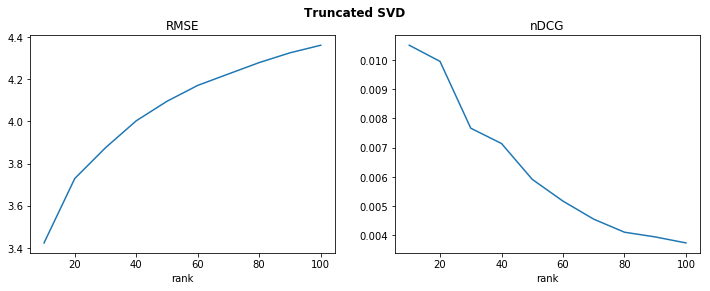

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
args = np.arange(10, 110, 10)

fig.suptitle('Truncated SVD', fontweight='bold')
ax1.plot(args, rmse_vals)
ax2.plot(args, ndcge_vals)
ax1.set_title('RMSE')
ax2.set_title('nDCG')
ax1.set_xlabel('rank')
ax2.set_xlabel('rank')

In [18]:
%%time
svd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=20, random_state=42)
low_rank = svd.fit_transform(train_matrix + val_matrix)
pred = svd.inverse_transform(low_rank)

CPU times: user 6.71 s, sys: 588 ms, total: 7.3 s
Wall time: 4.57 s


In [22]:
print 'Group'
print 'rmse', rmse_score(test_matrix[:, :],  pred[:, :]),'ndcg', ndcg_score(test_matrix[:, :],  pred[:, :])

Group
rmse 3.4688583713635834 ndcg 0.008623544885369636
